# Collect data from all submissions

*Author: R.A. Collenteur, 16th of March 2023*

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps

## 0. Teams overview



In [2]:
teams = pd.read_excel("../submissions/teams_overview.xlsx", header=[0,1], index_col=0)
teams = teams.drop("runwaygrey")  # Results do not seem correct, so not considered further
teams = teams.drop("regression")  # Results do not seem correct, so not considered further

teams

General Info                   General Info         Modelled              \
Team                                  Model    Type      USA Netherlands   
da_collective                        Pastas  lumped        1           1   
GEUS                                   LSTM      DL        1           1   
Janis                                    RF      ML        1           1   
LUHG                                 N-HiTS     NaN        1           1   
M2C_BRGM                        BC-MODWT-DL     NaN        1           1   
Mirkwood                                 RF      ML        1           1   
Selina_Yang                             SVR     NaN        0           1   
TUD                                    LSTM      DL        1           1   
RouhaniEtAl                             CNN     NaN        1           1   
gardenia                           Gardenia  Lumped        1           1   
HydroSight                       Hydrosight  Lumped        1           1   
MxNl           Ensemble of shallow learners     NaN        1           1   
TUV                             Transformer     NaN        1           1   
haidro                                 LSTM      DL        1           1   
uw                                      RNN     NaN        0           1   

General Info                              Time information  
Team          Germany Sweden_1 Sweden_2 Unnamed: 8_level_1  
da_collective       1        1        1                NaN  
GEUS                1        1        1                NaN  
Janis               1        1        1                NaN  
LUHG                1        1        1                NaN  
M2C_BRGM            1        1        1                NaN  
Mirkwood            1        1        1                NaN  
Selina_Yang         1        0        0                NaN  
TUD                 0        0        0                NaN  
RouhaniEtAl         1        1        1                NaN  
gardenia            1        1        1                NaN  
HydroSight          1        1        1                NaN  
MxNl                1        1        1                NaN  
TUV                 1        1        1                NaN  
haidro              1        1        1                NaN  
uw                  1        0        0                NaN

## 1. Create multiIndex DataFrame

In [3]:
team_names = teams.index
wells = teams.loc[:, ("Modelled", slice(None))].columns.get_level_values(1)
#wells = wells.drop("Sweden_1")
ts = ["Simulated Head", "95% Lower Bound", "95% Upper Bound"]
mi = pd.MultiIndex.from_product([team_names, wells, ts])

tmin = "2000-01-01"
tmax = "2022-12-31"
index = pd.date_range(tmin, tmax, freq="D")
df = pd.DataFrame(index=index, columns=mi)
df.head()

da_collective                                                 \
Team                  USA                                    Netherlands   
           Simulated Head 95% Lower Bound 95% Upper Bound Simulated Head   
2000-01-01            NaN             NaN             NaN            NaN   
2000-01-02            NaN             NaN             NaN            NaN   
2000-01-03            NaN             NaN             NaN            NaN   
2000-01-04            NaN             NaN             NaN            NaN   
2000-01-05            NaN             NaN             NaN            NaN   

                                                                           \
Team                                              Germany                   
           95% Lower Bound 95% Upper Bound Simulated Head 95% Lower Bound   
2000-01-01             NaN             NaN            NaN             NaN   
2000-01-02             NaN             NaN            NaN             NaN   
2000-01-03             NaN             NaN            NaN             NaN   
2000-01-04             NaN             NaN            NaN             NaN   
2000-01-05             NaN             NaN            NaN             NaN   

                                           ...              uw                 \
Team                             Sweden_1  ...     Netherlands        Germany   
           95% Upper Bound Simulated Head  ... 95% Upper Bound Simulated Head   
2000-01-01             NaN            NaN  ...             NaN            NaN   
2000-01-02             NaN            NaN  ...             NaN            NaN   
2000-01-03             NaN            NaN  ...             NaN            NaN   
2000-01-04             NaN            NaN  ...             NaN            NaN   
2000-01-05             NaN            NaN  ...             NaN            NaN   

                                                                           \
Team                                             Sweden_1                   
           95% Lower Bound 95% Upper Bound Simulated Head 95% Lower Bound   
2000-01-01             NaN             NaN            NaN             NaN   
2000-01-02             NaN             NaN            NaN             NaN   
2000-01-03             NaN             NaN            NaN             NaN   
2000-01-04             NaN             NaN            NaN             NaN   
2000-01-05             NaN             NaN            NaN             NaN   

                                                                           
Team                             Sweden_2                                  
           95% Upper Bound Simulated Head 95% Lower Bound 95% Upper Bound  
2000-01-01             NaN            NaN             NaN             NaN  
2000-01-02             NaN            NaN             NaN             NaN  
2000-01-03             NaN            NaN             NaN             NaN  
2000-01-04             NaN            NaN             NaN             NaN  
2000-01-05             NaN            NaN             NaN             NaN  

[5 rows x 225 columns]

## 2. Collect the actual data

In [4]:
d = "../submissions"
folders = [o for o in os.listdir(d) if os.path.isdir(os.path.join(d,o))]
folders.remove(".ipynb_checkpoints")
folders.remove("team_runwaygrey")
folders.remove("team_regression")

for i, folder in enumerate(folders, start=1):
    team = folder.replace("team_", "")
    for well in wells:
        if bool(teams.loc[team, ("Modelled", well)]) == True:
            fname = "submission_form_{}.csv".format(well)
            ts = pd.read_csv(os.path.join(d, folder,fname), index_col=0, parse_dates=True, 
                             usecols=["Date", "Simulated Head", "95% Lower Bound", "95% Upper Bound"]).squeeze().loc[tmin:tmax]
            ts.index = ts.index.round("D")
            df.loc[ts.index, (team, well, slice(None))] = ts.values
            
df.to_csv("../data/all_results.csv")

## 3. Plot simulated heads for quick check

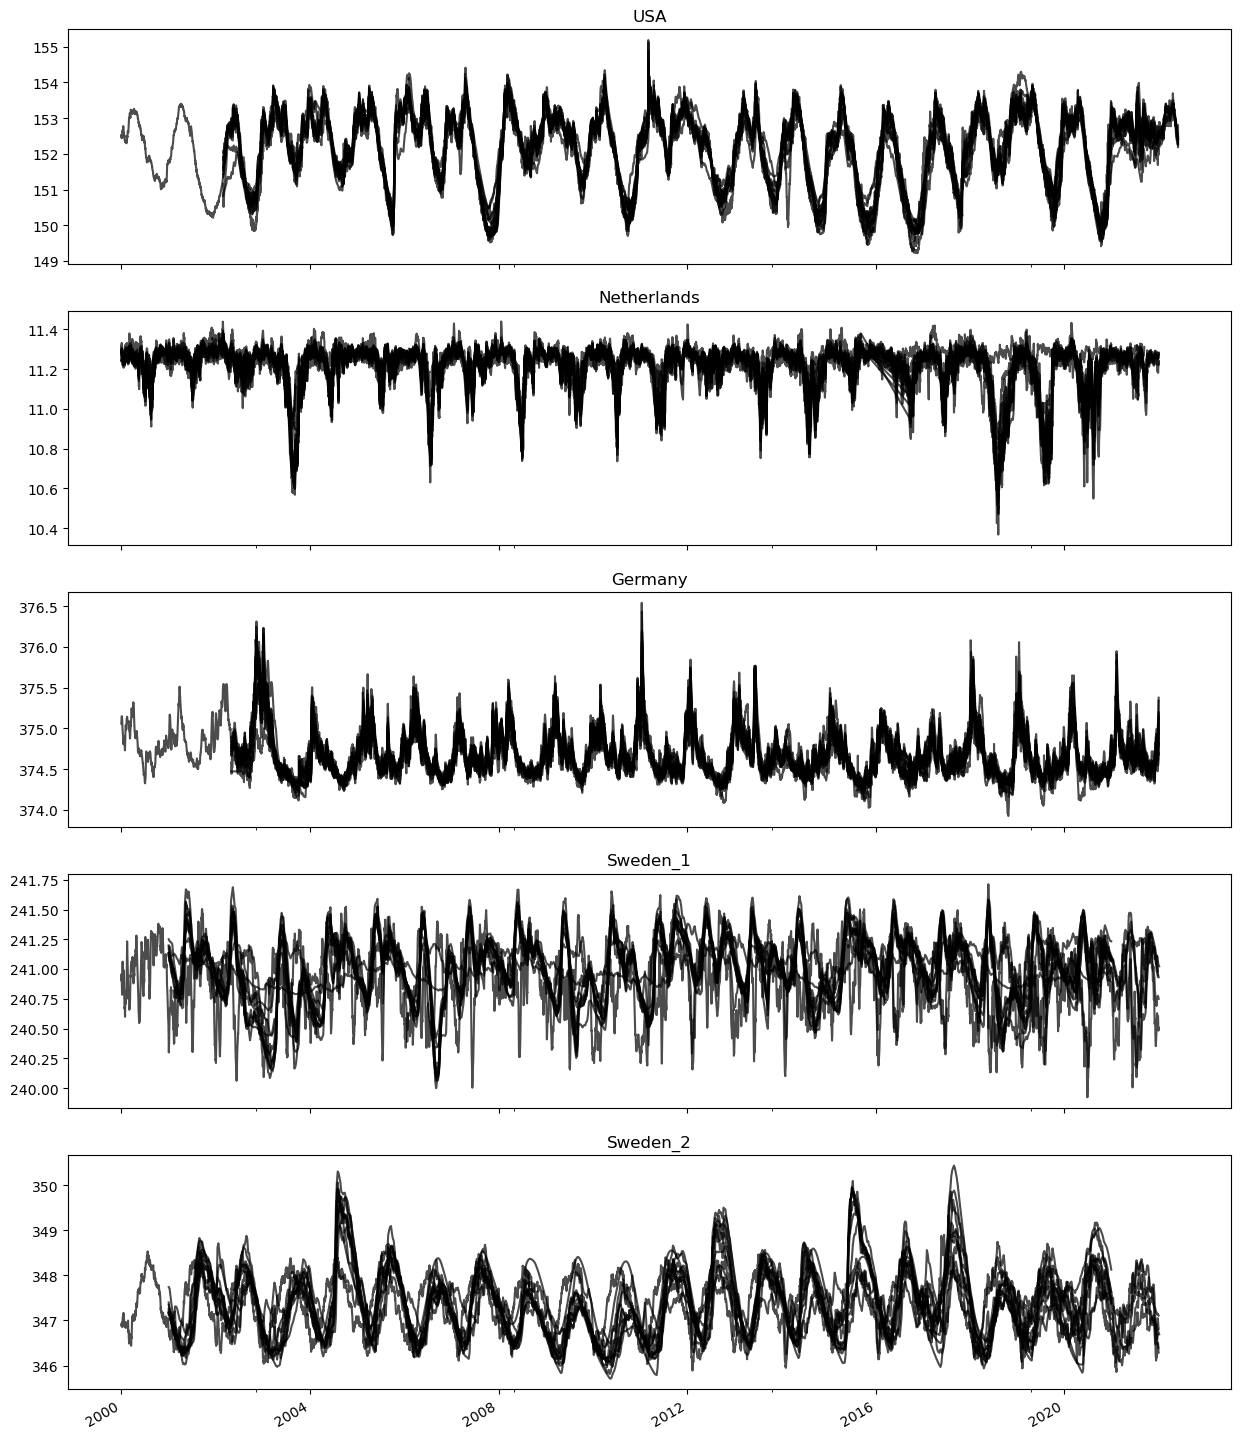

In [ ]:
fig, axes = plt.subplots(5,1, figsize=(15,20), sharex=True)
axes = axes.flatten()

for i, well in enumerate(wells):
    
    for _, ts in df.loc[:, (slice(None), well, "Simulated Head")].astype(float).items():
        ts.dropna().plot(ax=axes[i], x_compat=True, legend=False, color="k", alpha=0.7)
        
    axes[i].set_title(well)